In [2]:
from __future__ import print_function, division

from math import sqrt as ssqrt
from math import cos as scos
from math import fabs as fabs     # more restrictive than abs() (in a good way)
from numpy import *
from scipy import interpolate, integrate
from scipy.stats import lognorm
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import warnings
def CustomWarning(message, category, filename, lineno):
   print("%s:%s: %s:%s" % (filename, lineno, category.__name__, message))
warnings.showwarning = CustomWarning
from os import path
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import oscillation_prob as op

set_printoptions(precision=5, linewidth=150)

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Example

In [30]:
from __future__ import print_function, division

from numpy import *
max = amax
min = amin

import os, sys
from time import time
from sys import stdout
from NuCraft import *

# number of energy bins
eBins = 200
# energy range in GeV
eList = np.logspace(0, 2, eBins)
#linspace(1, 100, eBins)


# parameters from arxiv 1205.7071
# he is also using the approximation DM31 = DM32

DM32 = 2.51e-3
sin_squared_23 = 0.452
theta23 = np.arcsin(np.sqrt(sin_squared_23))/np.pi*180.
DM21   = 7.42e-5
sin_squared_13 = 0.02246
sin_squared_12 = 0.304
theta13 = arcsin(sqrt(sin_squared_13))/pi*180.
theta12 = arcsin(sqrt(sin_squared_12))/pi*180.

n_theta = 200   # 80 in the total cos-range
cos_theta = np.linspace(-1, 1, n_theta)    # the rest have probability approx. 1. 
# We are missing 80-56 = 24 that should be set equal to 1
zList = np.arccos(cos_theta)


# Akhemdov is implicitely assuming an electron-to-neutron ratio of 0.5; 
# he is also using the approximation DM31 = DM32;
# if you want to reproduce his numbers exactly, switch the lines below, and turn
# atmosphereMode to 0 (no handling of the atmosphere because of )
# AkhmedovOsci = NuCraft((1., DM21, DM31-DM21), [(1,2,theta12),(1,3,theta13,0),(2,3,theta23)],
#                        earthModel=EarthModel("prem", y=(0.5,0.5,0.5))
#                        detectorDepth=0., atmHeight=0.)
AkhmedovOsci = NuCraft((1., DM21, DM32), [(1,2,theta12),(1,3,theta13,0),(2,3,theta23)])

# To compute weights with a non-zero CP-violating phase, replace     ^  this zero
# by the corresponding angle (in degrees); this will add the phase to the theta13 mixing matrix,
# as it is done in the standard parametrization; alternatively, you can also add CP-violating
# phases to the other matrices, but in the 3-flavor case more than one phase are redundant.

# atmosphereMode = 0   # use fixed atmsopheric depth (set to 0 km if line 42 is not commented out)
atmosphereMode = 3   # default: efficiently calculate eight path lenghts per neutrino and take the average

# This parameter governs the precision with which nuCraft computes the weights; it is the upper
# limit for the deviation of the sum of the resulting probabilities from unitarity.
# You can verify this by checking the output plot example-standAlone2.png.
numPrec = 5e-4

# 12, -12:  NuE, NuEBar
# 14, -14:  NuMu, NuMuBar
# 16, -16:  NuTau, NuTauBar
pType = 14

print("Calculating...")

# saving the current time to measure the time needed for the execution of the following code
t = time()

### using lists (arrays, actually)
zListLong, eListLong = meshgrid(zList, eList)
zListLong = zListLong.flatten()
eListLong = eListLong.flatten()
tListLong = ones_like(eListLong)*pType

# actual call to nuCraft for weight calculations:
prob = AkhmedovOsci.CalcWeights((tListLong, eListLong, zListLong), numPrec=numPrec, atmMode=atmosphereMode)

prob = rollaxis( array(prob).reshape(len(eList), len(zList),-1), 0,3)
     # rollaxis is only needed to get the same shape as prob from above,
     # i.e., four elements for the different zenith angles, of which each is an
     # array of 3 x eBins (three oscillation probabilities for every energy bin)

print("Calculating the probabilities took %f seconds." % (time()-t))
print( " \n Completed without fatal errors! \n " )

Calculating...
Calculating the probabilities took 165.038114 seconds.
 
 Completed without fatal errors! 
 


In [28]:
prob_numu_to_nutau = np.zeros((200, eBins))
prob_numu_to_numu = np.zeros((200, eBins))
prob_numu_to_nue = np.zeros((200, eBins))

for i in range(200):
        prob_numu_to_nue[i] = prob[i][0]
        prob_numu_to_numu[i] = prob[i][1]
        prob_numu_to_nutau[i] = prob[i][2]

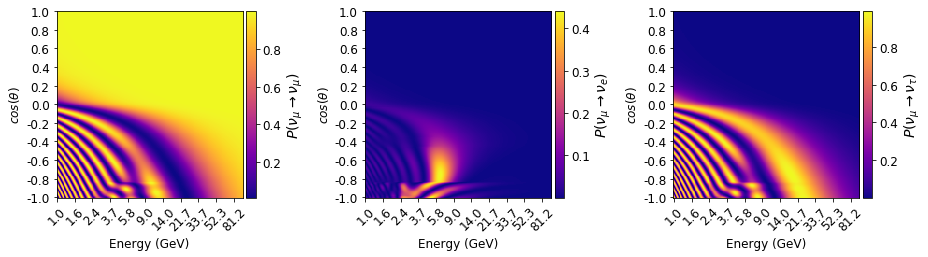

In [18]:
cos_theta_label = np.linspace(-1, 1, 201)

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax.ravel()

im = ax[0].imshow(prob_numu_to_numu, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$', fontsize=14)

im = ax[1].imshow(prob_numu_to_nue, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$P(\nu_{\mu} \rightarrow \nu_e)$', fontsize=14)

im = ax[2].imshow(prob_numu_to_nutau, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$P(\nu_{\mu} \rightarrow \nu_{\tau})$', fontsize=14)

for i in range(3):
    ax[i].set_xlabel('Energy (GeV)', fontsize=12)
    ax[i].set_ylabel(r'$cos(\theta)$', fontsize=12)
    ax[i].set_xticks(np.arange(0, 200, 19))
    ax[i].set_xticklabels([f'{np.round(eList[i],1)}' for i in np.arange(0, 200, 19)], rotation=45)
    ax[i].set_yticks(np.arange(0, 201, 20))
    ax[i].set_yticklabels([f'{np.round(cos_theta_label[i],1)}' for i in np.arange(0, 201, 20)])


fig.tight_layout()
fig.savefig('NuCraft_oscillations')

In [21]:
# Binning
cos_theta_binning = np.linspace(-1, 1, 80)

# cos intervals for binning
cos_intervals = np.round(np.arange(1, -1, -0.1), 2)
cos_bins = np.digitize(cos_theta_binning, cos_intervals, right=True)                                
    
# energy intervals
energy_min = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(eList, energy_min)
energy_binwidths = energy_max - energy_min

In [22]:
# Labels 

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min, energy_max[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

In [23]:
def bin_matrix(matrix, make_plot = False, savefig = None):
    
    #Binning
    matrix_ybinned = np.zeros((len(cos_intervals) , len(matrix[0])))

    # averaging rows in same interval
    for i in range(1, len(cos_intervals)+1):
        rows = np.where(cos_bins == i)[0]
        averaged_row = np.mean(matrix[rows[0] : rows[-1]+1, : ], axis = 0)
        matrix_ybinned[ i-1 , : ] = averaged_row
    
    binned_matrix = np.zeros((len(cos_intervals), len(energy_min)))  

    # averaging columns in same interval
    for i in range(1, len(energy_min)+1):
        columns = np.where(energy_bins == i)[0]
        averaged_column = np.mean(matrix_ybinned[ : , columns[0] : columns[-1]+1], axis = 1)
        binned_matrix[ : , i-1 ] = averaged_column
        
    if make_plot == True:
        fig, ax = plt.subplots(figsize=(10,7))

        im = ax.imshow(binned_matrix, cmap='plasma')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = plt.colorbar(im, cax=cax)
        ax.set_xlabel('Energy (GeV)')
        ax.set_ylabel(r'$cos(\theta_{zenith})$')
        ax.set_xticks(xticks)
        ax.set_xticklabels(energy_strings, rotation = 45)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        cbar_label = r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$'
        cbar.set_label(cbar_label)
        
        if savefig != None:
            fig.savefig(savefig)
        
    return binned_matrix

In [25]:
DM32_true = 2.51e-3
sin_squared_23 = 0.452
theta23_true = np.arcsin(np.sqrt(sin_squared_23))/np.pi*180.

#_, os_prob = op.oscillation_prob(theta23_true, DM32_true)

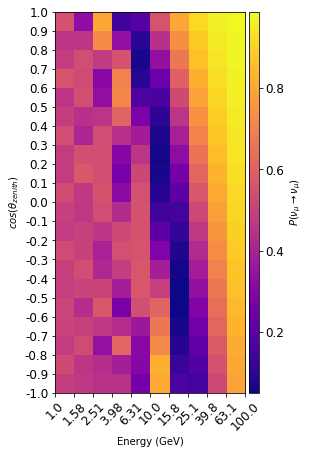

In [26]:
binned_prob_numu_to_numu = bin_matrix(prob_numu_to_numu, make_plot=True) #, savefig = 'numu_oscillation_binned')

In [145]:
np.savetxt('prob_numu_to_numu', binned_prob_numu_to_numu, delimiter=',')